In [1]:
import pandas          as pd
import numpy           as np
import geopandas       as gpd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.svm             import SVR
from sklearn.neural_network  import MLPRegressor

from sklearn.preprocessing   import StandardScaler, PolynomialFeatures

import matplotlib.pyplot    as plt
import seaborn              as sns

from   matplotlib           import cm
from   mpl_toolkits.mplot3d import Axes3D
from   sklearn.tree         import plot_tree

from sklearn.metrics        import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import tensorflow as tf
from   tensorflow.keras.models       import Sequential
from   tensorflow.keras.layers       import Dense, Dropout
from   tensorflow.keras.activations  import relu, tanh, sigmoid
from   tensorflow.keras.regularizers import l1_l2

from sklearn.pipeline import Pipeline, make_pipeline


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Set plot style
sns.set_style('whitegrid')


In [5]:
# Load the data from the provided Excel file
file_path = "C:\\CoventryMl\\11215866-NDA-s1\\Coursework_1\\datasets\\Plastic Pollution_population_data_20.10.2023.xlsx"

# Loading GDP and Population data from the other sheets in the Excel file
gdp_df = pd.read_excel(file_path, sheet_name=1)
population_df = pd.read_excel(file_path, sheet_name=2)
plastic_df = pd.read_excel(file_path, sheet_name=0)

# Displaying basic info and the first few rows of the GDP, Population, and Plastic dataframes
gdp_df.info(), gdp_df.head(), population_df.info(), population_df.head(), plastic_df.info(), plastic_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unnamed: 0                                     218 non-null    object 
 1   Unnamed: 1                                     218 non-null    object 
 2   Unnamed: 2                                     218 non-null    object 
 3   The World Bank - World Development Indicators  204 non-null    object 
 4   Unnamed: 4                                     204 non-null    float64
 5   Unnamed: 5                                     208 non-null    float64
 6   Unnamed: 6                                     208 non-null    float64
 7   Unnamed: 7                                     208 non-null    float64
 8   Unnamed: 8                                     208 non-null    float64
 9   Unnamed: 9                                     209 non

(None,
   Unnamed: 0      Unnamed: 1    Unnamed: 2  \
 0        NaN             NaN           NaN   
 1        NaN             NaN           NaN   
 2         ss  Country Namedd  Country Code   
 3          1         Albania            A1   
 4          2         Algeria            A2   
 
        The World Bank - World Development Indicators    Unnamed: 4  \
 0  https://data.worldbank.org/indicator/NY.GDP.MK...           NaN   
 1                       Gross domestic product (GDP)           NaN   
 2                                               2000  2.001000e+03   
 3                                   3480355258.04122  3.922101e+09   
 4                                 54790398813.000504  5.474470e+10   
 
      Unnamed: 5    Unnamed: 6    Unnamed: 7    Unnamed: 8    Unnamed: 9  ...  \
 0           NaN           NaN           NaN           NaN           NaN  ...   
 1           NaN           NaN           NaN           NaN           NaN  ...   
 2  2.002000e+03  2.003000e+03  2.0040

In [6]:
# Function to clean and melt the dataframes
# Modifying the function to handle different column names for country and year columns
def clean_and_melt(df, value_var, country_col, code_col, drop_rows=3):
    # Setting new column names based on the content of the third row
    df.columns = df.iloc[2]
    df = df.drop([0, 1, 2])
    df.reset_index(drop=True, inplace=True)
    
    # Melting the dataframe
    df_melted = df.melt(id_vars=['ss', country_col, code_col], var_name='Year', value_name=value_var)
    return df_melted

# Applying the modified function to each dataframe
gdp_melted = clean_and_melt(gdp_df, 'GDP', 'Country Namedd', 'Country Code')
population_melted = clean_and_melt(population_df, 'Population', 'Country Namedd', 'Country Code')
# Applying the modified function to the plastic pollution dataframe with corrected column names
plastic_melted = clean_and_melt(plastic_df, 'Mismanaged Plastic', 'Country', 'Code')


# Displaying the first few rows of each melted dataframe
gdp_melted.head(), population_melted.head(), plastic_melted.head()

(  ss       Country Namedd Country Code  Year                 GDP
 0  1              Albania           A1  2000    3480355258.04122
 1  2              Algeria           A2  2000  54790398813.000504
 2  3               Angola           A3  2000   9129594818.607491
 3  4  Antigua and Barbuda           A4  2000     826370370.37037
 4  5            Argentina           A5  2000        284203750000,
   ss       Country Namedd Country Code    Year  Population
 0  1              Albania           A1  2000.0   3089027.0
 1  2              Algeria           A2  2000.0  30774621.0
 2  3               Angola           A3  2000.0  16394062.0
 3  4  Antigua and Barbuda           A4  2000.0     75055.0
 4  5            Argentina           A5  2000.0  37070774.0,
   ss              Country Code    Year Mismanaged Plastic
 0  1              Albania   A1  2000.0       10036.090367
 1  2              Algeria   A2  2000.0      259690.609786
 2  3               Angola   A3  2000.0       72344.966716
 3  4 

In [7]:
# Merging the three melted dataframes based on common columns
merged_df = plastic_melted.merge(gdp_melted, left_on=['ss', 'Country', 'Code', 'Year'], 
                                right_on=['ss', 'Country Namedd', 'Country Code', 'Year'])
merged_df = merged_df.merge(population_melted, left_on=['ss', 'Country', 'Code', 'Year'], 
                            right_on=['ss', 'Country Namedd', 'Country Code', 'Year'])

# Dropping duplicated or unnecessary columns
columns_to_drop = ['Country Namedd_x', 'Country Code_x', 'Country Namedd_y', 'Country Code_y']
merged_df = merged_df.drop(columns=columns_to_drop)

# Sorting the dataframe by Country and Year
merged_df_sorted = merged_df.sort_values(by=['Country', 'Year']).reset_index(drop=True)

# Displaying the first few rows of the merged dataframe
merged_df_sorted.head()

,ss,Country,Code,Year,Mismanaged Plastic,GDP,Population
0,1,Albania,A1,2000.0,10036.090367,3480355258.04122,3089027.0
1,1,Albania,A1,2001,10519.018571,3922100793.5403,3060173.0
2,1,Albania,A1,2002,11169.706636,4348068242.19512,3051010.0
3,1,Albania,A1,2003.0,11774.533405,5611496257.14231,3039616.0
4,1,Albania,A1,2004.0,12468.679688,7184685781.51876,3026939.0


In [8]:
# Converting the Year column to integer type after removing any potential NaN values
merged_df_sorted = merged_df_sorted.dropna(subset=['Year'])
merged_df_sorted['Year'] = merged_df_sorted['Year'].astype(int)

# Displaying the first few rows of the updated dataframe
merged_df_sorted.head(30)

,ss,Country,Code,Year,Mismanaged Plastic,GDP,Population
0,1,Albania,A1,2000,10036.090367,3480355258.04122,3089027.0
1,1,Albania,A1,2001,10519.018571,3922100793.5403,3060173.0
2,1,Albania,A1,2002,11169.706636,4348068242.19512,3051010.0
3,1,Albania,A1,2003,11774.533405,5611496257.14231,3039616.0
4,1,Albania,A1,2004,12468.679688,7184685781.51876,3026939.0
5,1,Albania,A1,2005,13030.505477,8052077209.3737,3011487.0
6,1,Albania,A1,2006,13753.370505,8896074996.358761,2992547.0
7,1,Albania,A1,2007,14509.481018,10677324872.8286,2970017.0
8,1,Albania,A1,2008,14705.514518,12881352878.250099,2947314.0
9,1,Albania,A1,2009,15226.183306,12044205572.4342,2927519.0


In [9]:
# Saving the sorted and merged data to a CSV file
file_path_csv = 'C:\CoventryMl\\11215866-NDA-s1\Coursework_1\datasetsCleaned_Plastic_Pollution_Data.csv'
merged_df_sorted.to_csv(file_path_csv, index=False)

file_path_csv


'C:\\CoventryMl\\11215866-NDA-s1\\Coursework_1\\datasetsCleaned_Plastic_Pollution_Data.csv'

In [10]:
# Load the first dataset
df_per_capita_vs_gdp = pd.read_csv('C:\\CoventryMl\\11215866-NDA-s1\\Coursework_1\\datasetsCleaned_Plastic_Pollution_Data.csv')

# Display the first few rows of the dataset
df_per_capita_vs_gdp.head()

,ss,Country,Code,Year,Mismanaged Plastic,GDP,Population
0,1.0,Albania,A1,2000,10036.090367,3.480355e+09,3089027.0
1,1.0,Albania,A1,2001,10519.018571,3.922101e+09,3060173.0
2,1.0,Albania,A1,2002,11169.706636,4.348068e+09,3051010.0
3,1.0,Albania,A1,2003,11774.533405,5.611496e+09,3039616.0
4,1.0,Albania,A1,2004,12468.679688,7.184686e+09,3026939.0


In [11]:
# Set the display format to be float format
pd.options.display.float_format = '{:.0f}'.format

In [12]:
df_selected_columns = df_per_capita_vs_gdp[['Mismanaged Plastic', 'GDP', 'Population']]

# Getting a summary of the selected columns
summary_selected_columns = df_selected_columns.describe()

# Calculating the median of the selected columns
median_selected_columns = df_selected_columns.median()


summary_selected_columns, median_selected_columns

(       Mismanaged Plastic            GDP  Population
 count                3360           3221        3360
 mean               364862   372246327379    38253115
 std               1369485  1488630498465   144180127
 min                    72       13964729        9609
 25%                  7224     4323339212      533920
 50%                 50361    22823271521     5231346
 75%                235057   179663390875    25590576
 max              18450720 21380976119000  1407745000,
 Mismanaged Plastic         50361
 GDP                  22823271521
 Population               5231346
 dtype: float64)

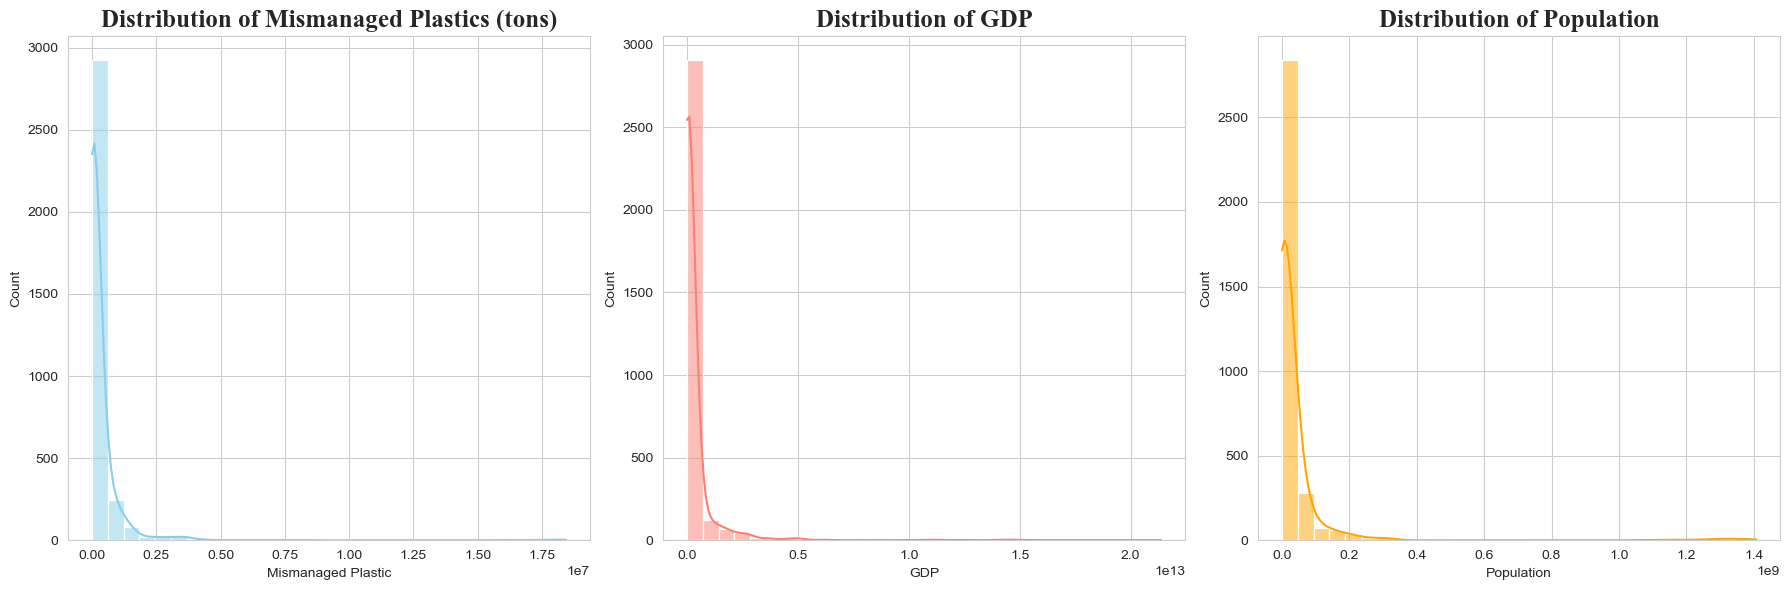

In [25]:
# Initialize the figure
plt.figure(figsize=(18, 6))

# Plotting histograms
plt.subplot(1, 3, 1)

sns.histplot(data=df_per_capita_vs_gdp, x='Mismanaged Plastic', bins=30, color='skyblue', kde=True)
plt.title('Distribution of Mismanaged Plastics (tons)', fontsize=18, fontname="Times New Roman", fontweight="bold")

plt.subplot(1, 3, 2)
sns.histplot(data=df_per_capita_vs_gdp, x='GDP', bins=30, color='salmon', kde=True)
plt.title('Distribution of GDP', fontsize=18, fontname="Times New Roman", fontweight="bold")


plt.subplot(1, 3, 3)
sns.histplot(data=df_per_capita_vs_gdp, x='Population', bins=30, color='orange', kde=True)
plt.title('Distribution of Population', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.tight_layout()
plt.show()



# Displaying the plot
plt.show()

In [14]:
# Calculate number of missing values and percentage of missing values for each column
missing_values = pd.DataFrame(df_per_capita_vs_gdp.isnull().sum(), columns=['Missing Values'])
missing_values['% of Total Values'] = (df_per_capita_vs_gdp.isnull().sum() / len(df_per_capita_vs_gdp)) * 100

missing_values.sort_values(by='% of Total Values', ascending=False)


,Missing Values,% of Total Values
GDP,259,7
ss,120,3
Country,120,3
Code,120,3
Mismanaged Plastic,120,3
Population,120,3
Year,0,0


In [15]:
# Filter rows
filtered_data = df_per_capita_vs_gdp[df_per_capita_vs_gdp['Mismanaged Plastic'].notnull()]


# Calculate the number and percentage of missing values in the filtered dataset
missing_data_filtered = pd.DataFrame(filtered_data.isnull().sum(), columns=['Missing Values'])
missing_data_filtered['% of Total Values'] = (filtered_data.isnull().sum() / len(filtered_data)) * 100

missing_data_filtered.sort_values(by='% of Total Values', ascending=False)

,Missing Values,% of Total Values
GDP,139,4
ss,0,0
Country,0,0
Code,0,0
Year,0,0
Mismanaged Plastic,0,0
Population,0,0


In [16]:
# Create a subset by dropping rows with missing GDP values
data_subset_no_missing_gdp = filtered_data.dropna(subset=['GDP'])

# Impute missing values in the main dataset
filtered_data['GDP'].fillna(filtered_data['GDP'].median(), inplace=True)


# Check if there are any remaining missing values in the main dataset
missing_data_final = pd.DataFrame(filtered_data.isnull().sum(), columns=['Missing Values'])
missing_data_final['% of Total Values'] = (filtered_data.isnull().sum() / len(filtered_data)) * 100

missing_data_final, data_subset_no_missing_gdp.shape


(                    Missing Values  % of Total Values
 ss                               0                  0
 Country                          0                  0
 Code                             0                  0
 Year                             0                  0
 Mismanaged Plastic               0                  0
 GDP                              0                  0
 Population                       0                  0,
 (3221, 7))

In [17]:
# Display data information including data types and non-null counts
data_info = filtered_data.info()

# Display summary statistics for numerical columns
data_summary = filtered_data.describe()

data_info, data_summary

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3360 entries, 0 to 3359
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ss                  3360 non-null   float64
 1   Country             3360 non-null   object 
 2   Code                3360 non-null   object 
 3   Year                3360 non-null   int64  
 4   Mismanaged Plastic  3360 non-null   float64
 5   GDP                 3360 non-null   float64
 6   Population          3360 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 210.0+ KB


(None,
         ss  Year  Mismanaged Plastic            GDP  Population
 count 3360  3360                3360           3360        3360
 mean    84  2010              364862   357791028342    38253115
 std     49     6             1369485  1459164932739   144180127
 min      1  2000                  72       13964729        9609
 25%     43  2005                7224     4658185189      533920
 50%     84  2010               50361    22823271521     5231346
 75%    126  2014              235057   168187420740    25590576
 max    168  2019            18450720 21380976119000  1407745000)

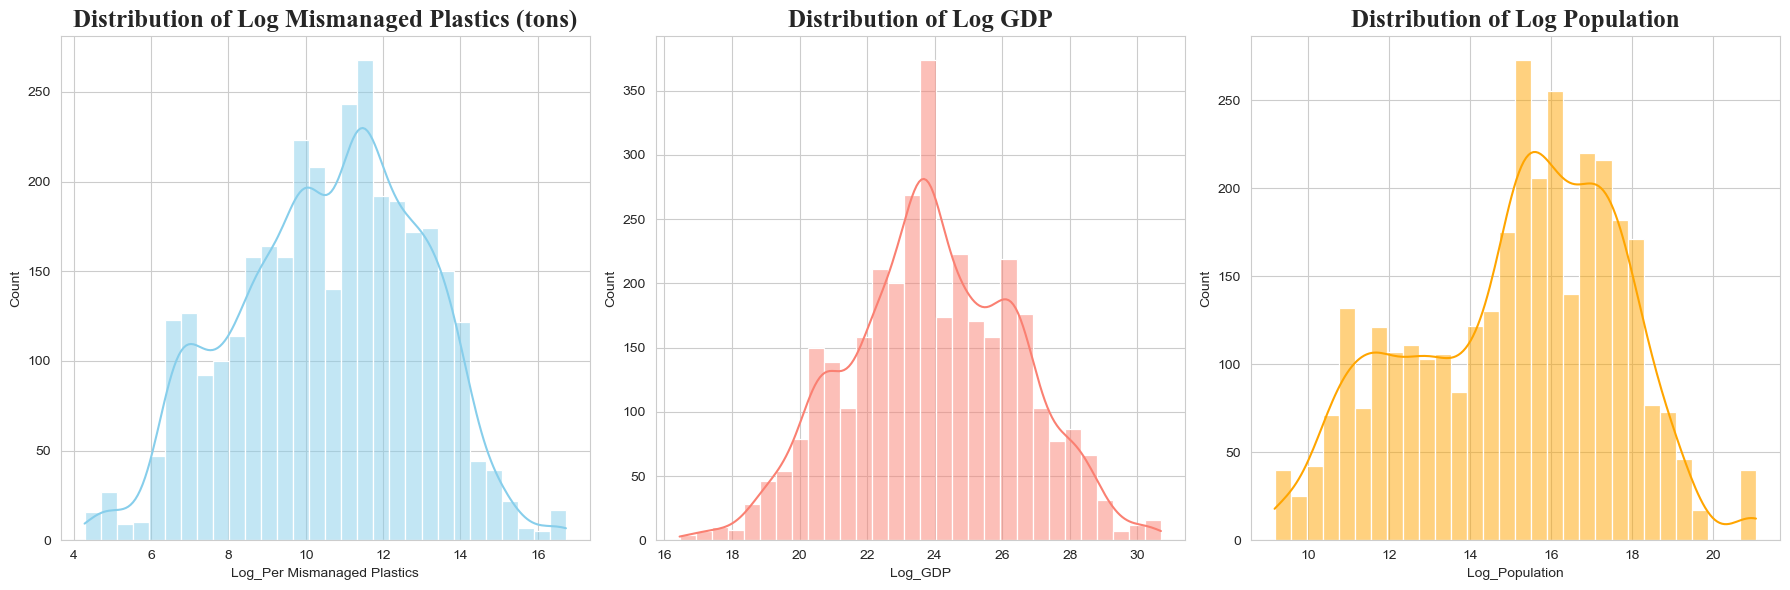

In [18]:
# Apply log transformation (adding a small constant to avoid log(0))
filtered_data['Log_Per Mismanaged Plastics'] = np.log(filtered_data['Mismanaged Plastic'] + 0.001)
filtered_data['Log_Mismanaged_Plastics'] = np.log(filtered_data['Mismanaged Plastic'] + 0.001)
filtered_data['Log_GDP'] = np.log(filtered_data['GDP'] + 0.001)


filtered_data['Log_Population'] = np.log(filtered_data['Population'] + 0.001)

# Visualize the transformed data
plt.figure(figsize=(18, 6))

# Histogram for log-transformed
plt.subplot(1, 3, 1)
sns.histplot(data=filtered_data, x='Log_Per Mismanaged Plastics', bins=30, color='skyblue', kde=True)
plt.title('Distribution of Log Mismanaged Plastics (tons)', fontsize=18, fontname="Times New Roman", fontweight="bold")

# Histogram for log-transformed 'GDP per capita'
plt.subplot(1, 3, 2)
sns.histplot(data=filtered_data, x='Log_GDP', bins=30, color='salmon', kde=True)
plt.title('Distribution of Log GDP',fontsize=18, fontname="Times New Roman", fontweight="bold")

# Histogram for log-transformed 'GDP per capita'
plt.subplot(1, 3, 3)
sns.histplot(data=filtered_data, x='Log_Population', bins=30, color='orange', kde=True)
plt.title('Distribution of Log Population',fontsize=18, fontname="Times New Roman", fontweight="bold")

plt.tight_layout()
plt.show()

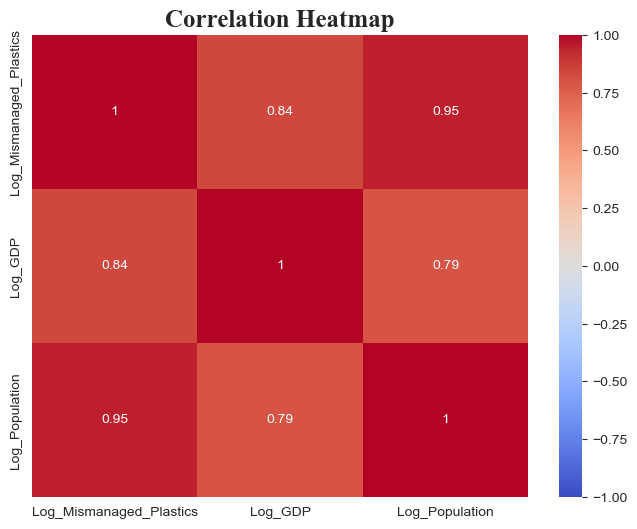

In [19]:
# Calculate the correlation matrix for the log-transformed variables
correlation_matrix = filtered_data[['Log_Mismanaged_Plastics', 'Log_GDP', 'Log_Population']].corr()

# Visualize the correlation using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.show()


In [20]:
# Extracting the independent and dependent variables
X_clean_test = filtered_data[['Log_GDP','Log_Population']]
y_clean_test = filtered_data['Log_Per Mismanaged Plastics']

In [21]:
# Adding a constant to the model (intercept)
X_clean_test_with_const = sm.add_constant(X_clean_test)

# Fitting the OLS model
model = sm.OLS(y_clean_test, X_clean_test_with_const).fit()

# Getting a summary of the regression
model_summary = model.summary()
print(model_summary)

                                 OLS Regression Results                                
Dep. Variable:     Log_Per Mismanaged Plastics   R-squared:                       0.922
Model:                                     OLS   Adj. R-squared:                  0.922
Method:                          Least Squares   F-statistic:                 1.994e+04
Date:                         Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                                 22:36:51   Log-Likelihood:                -3389.2
No. Observations:                         3360   AIC:                             6784.
Df Residuals:                             3357   BIC:                             6803.
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [22]:
# Fitting the linear regression model
model = LinearRegression()
model.fit(X_clean_test, y_clean_test)

# Predicting the dependent variable values
y_pred = model.predict(X_clean_test)

# Calculating R^2 and RMSE
mae = mean_absolute_error(y_clean_test, y_pred)
mse = mean_squared_error(y_clean_test, y_pred)
r2 = r2_score(y_clean_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_clean_test, y_pred))


mae, mse, r2, rmse

(0.4822417446517056,
 0.4402188270305751,
 0.9223752487456949,
 0.6634898846482703)

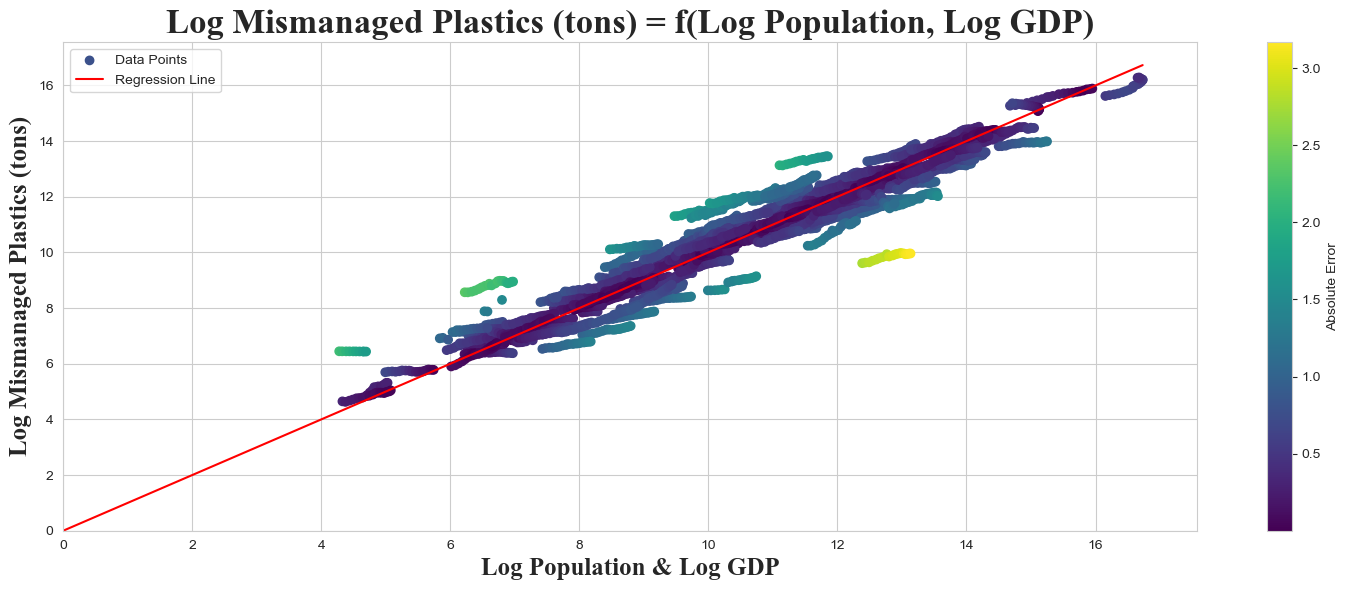

In [28]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(y_clean_test, y_pred, c=np.abs(y_clean_test-y_pred), cmap='viridis')
plt.colorbar(scatter, label='Absolute Error')
plt.plot([0, max(y_clean_test)], [0, max(y_clean_test)], color='red') # Diagonal line starting from (0,0)
plt.title('Log Mismanaged Plastics (tons) = f(Log Population, Log GDP)', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.xlabel('Log Population & Log GDP', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Log Mismanaged Plastics (tons)', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.legend(['Data Points', 'Regression Line'])
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

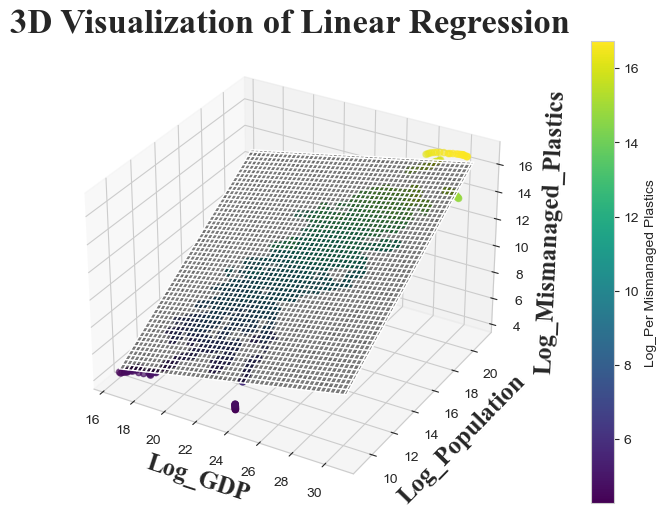

In [178]:
# Creating a 3D plot to visualize the regression plane
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid for the plane
x1, x2 = np.meshgrid(np.linspace(X_clean_test['Log_GDP'].min(), X_clean_test['Log_GDP'].max(), 100),
                     np.linspace(X_clean_test['Log_Population'].min(), X_clean_test['Log_Population'].max(), 100))

# Predicting values using the model to find the coordinates for the Z axis
Z = model.predict(np.c_[x1.ravel(), x2.ravel()])
Z = Z.reshape(x1.shape)

# Plotting the regression plane
ax.plot_surface(x1, x2, Z, color='None', alpha=0.5)

# Scatter plot of the original data
scatter = ax.scatter(X_clean_test['Log_GDP'], X_clean_test['Log_Population'], y_clean_test, 
                     c=y_clean_test, cmap='viridis')
cbar = fig.colorbar(scatter)
cbar.set_label('Log_Per Mismanaged Plastics')

# Setting labels
ax.set_xlabel('Log_GDP', fontsize=18, fontname="Times New Roman", fontweight="bold")
ax.set_ylabel('Log_Population', fontsize=18, fontname="Times New Roman", fontweight="bold")
ax.set_zlabel('Log_Mismanaged_Plastics', fontsize=18, fontname="Times New Roman", fontweight="bold")
ax.set_title('3D Visualization of Linear Regression', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.show()

#### Linear Regression.

In [30]:

# Features and Target
X = filtered_data[['Log_GDP','Log_Population']]
y = filtered_data['Log_Per Mismanaged Plastics']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions   
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Getting the coefficient of the model
coefficient = lr.coef_

# Evaluation
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Printing the coefficient and intercept
print(f'Coefficient: {coefficient}')
mae, mse, r2, rmse


Coefficient: [0.23399718 0.70724306]


(0.4641970448071224,
 0.4190533484580268,
 0.9329315399809252,
 0.6473433003113779)

##

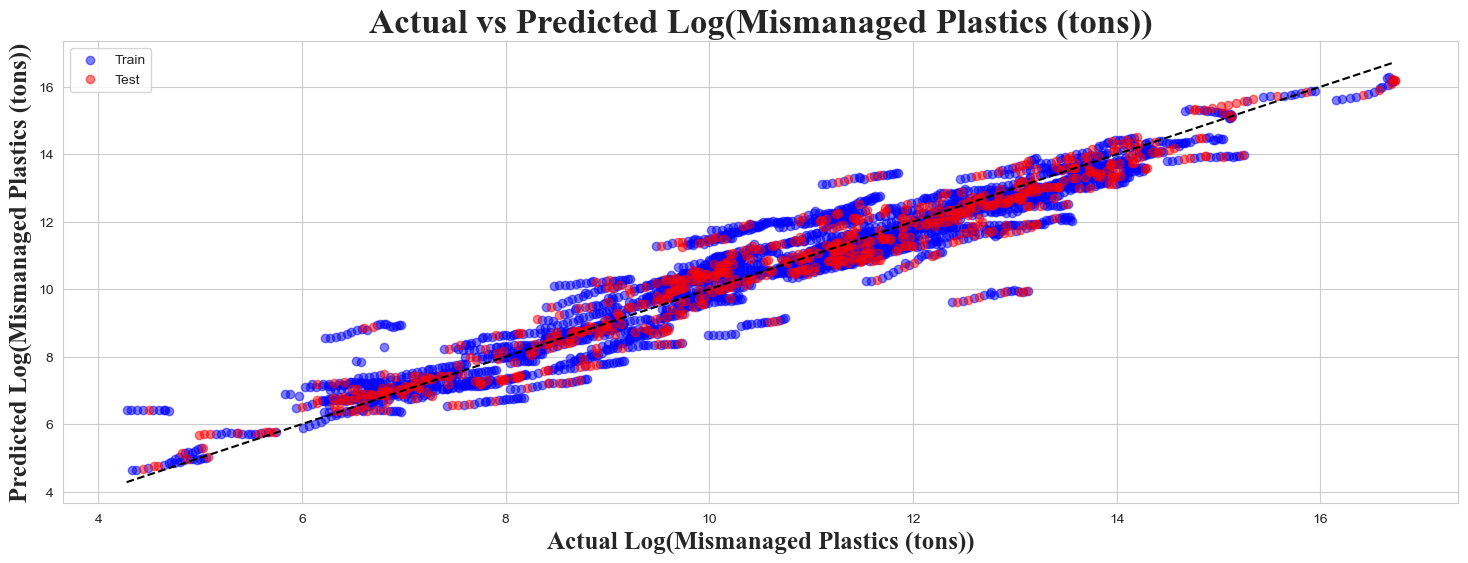

In [31]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(18, 6))

# Scatter plot for training data
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5, label='Train')

# Scatter plot for testing data
plt.scatter(y_test, y_pred_test, color='red', alpha=0.5, label='Test')

# Plotting the line for perfect prediction
min_val = min(min(y_train), min(y_test))
max_val = max(max(y_train), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.xlabel('Actual Log(Mismanaged Plastics (tons))',fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Log(Mismanaged Plastics (tons))', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Actual vs Predicted Log(Mismanaged Plastics (tons))',fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()

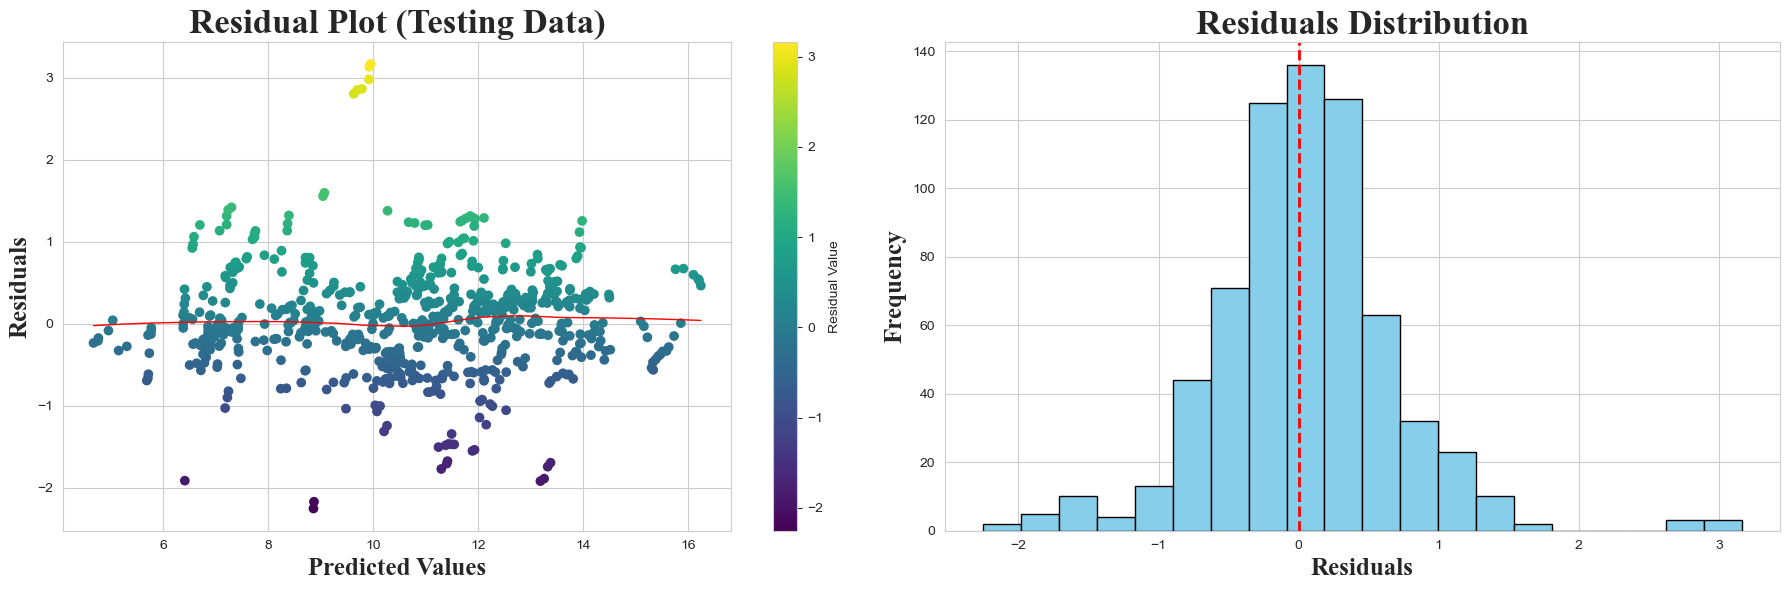

In [94]:
# Calculating residuals for training and testing data
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Function to create a colored residual plot with a lowess line
def colored_residual_plot(predictions, residuals, title):
    # Creating a scatter plot with a color map
    scatter = plt.scatter(predictions, residuals, c=residuals, cmap='viridis')
    plt.colorbar(scatter).set_label('Residual Value')
    
    # Adding a lowess line
    sns.regplot(x=predictions, y=residuals, lowess=True, scatter=False, color='red', line_kws={'lw': 1})
    
    # Adding labels and title
    plt.xlabel('Predicted Values',fontsize=18, fontname="Times New Roman", fontweight="bold")
    plt.ylabel('Residuals',fontsize=18, fontname="Times New Roman", fontweight="bold")
    plt.title(title, fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.figure(figsize=(18, 6))
# Creating the residual plot using seaborn for training data


# Creating a colored residual plot for testing data
plt.subplot(1, 2, 1)
colored_residual_plot(y_pred_test, residuals_test, 'Residual Plot (Testing Data)')


# Residuals Distribution
plt.subplot(1, 2, 2)

plt.hist(residuals_test, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")
# Displaying the plots
plt.tight_layout()
plt.show()

## Polynomial features 

In [95]:
# Degree of the polynomial. You can modify this value to have more complex polynomials
degree = 2 

# Creating a model that includes polynomial features
polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())

# Fitting the model
polyreg.fit(X_train, y_train)

# Making predictions
y_pred_train_poly = polyreg.predict(X_train)
y_pred_test_poly = polyreg.predict(X_test)


In [96]:
# Evaluating the model
mae_poly = mean_absolute_error(y_test, y_pred_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_test_poly)
r2_poly = r2_score(y_test, y_pred_test_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_test_poly))
mae_poly, mse_poly, r2_poly, rmse_poly

(0.4491396328574514,
 0.38577215093982675,
 0.9382581139681031,
 0.6211055875934677)

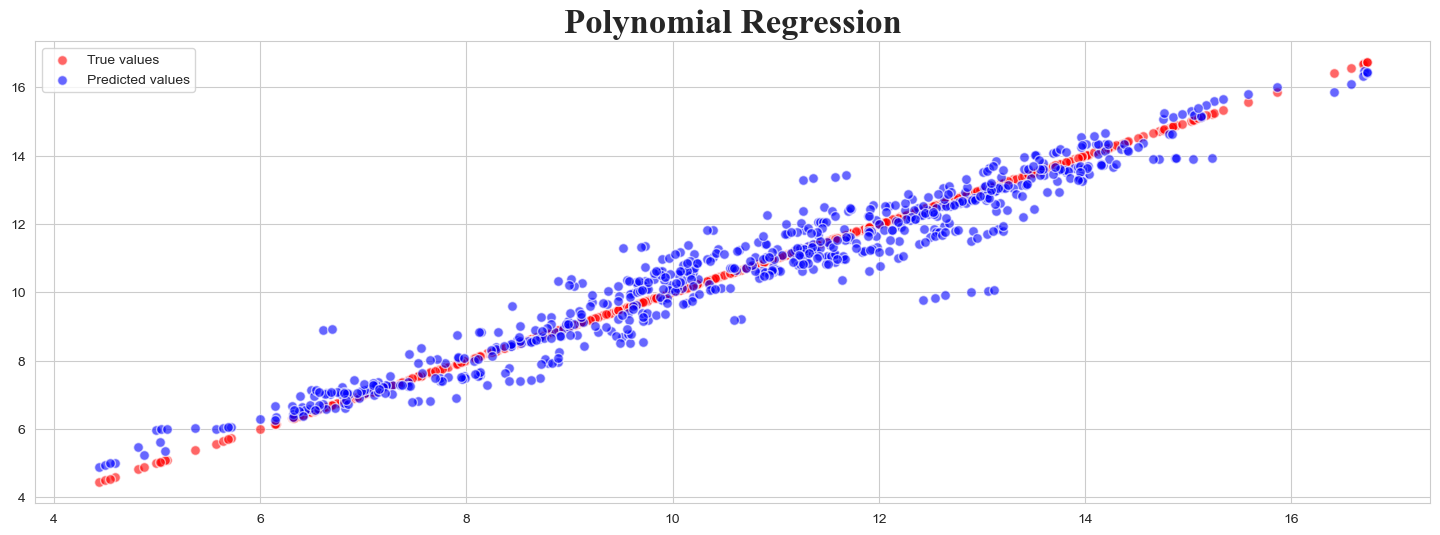

In [97]:
# Visualizing the results

residuals= y_test-y_pred_test_poly

plt.figure(figsize=(18, 6))
plt.scatter(y_test, y_test, color='red', label='True values', alpha=0.6, s=50, edgecolor='white')
plt.scatter(y_test, y_pred_test_poly, color='blue', label='Predicted values', alpha=0.6, s=50, edgecolor='white')
plt.title('Polynomial Regression', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.legend()

plt.show()



Text(0.5, 1.0, 'Residuals Distribution')

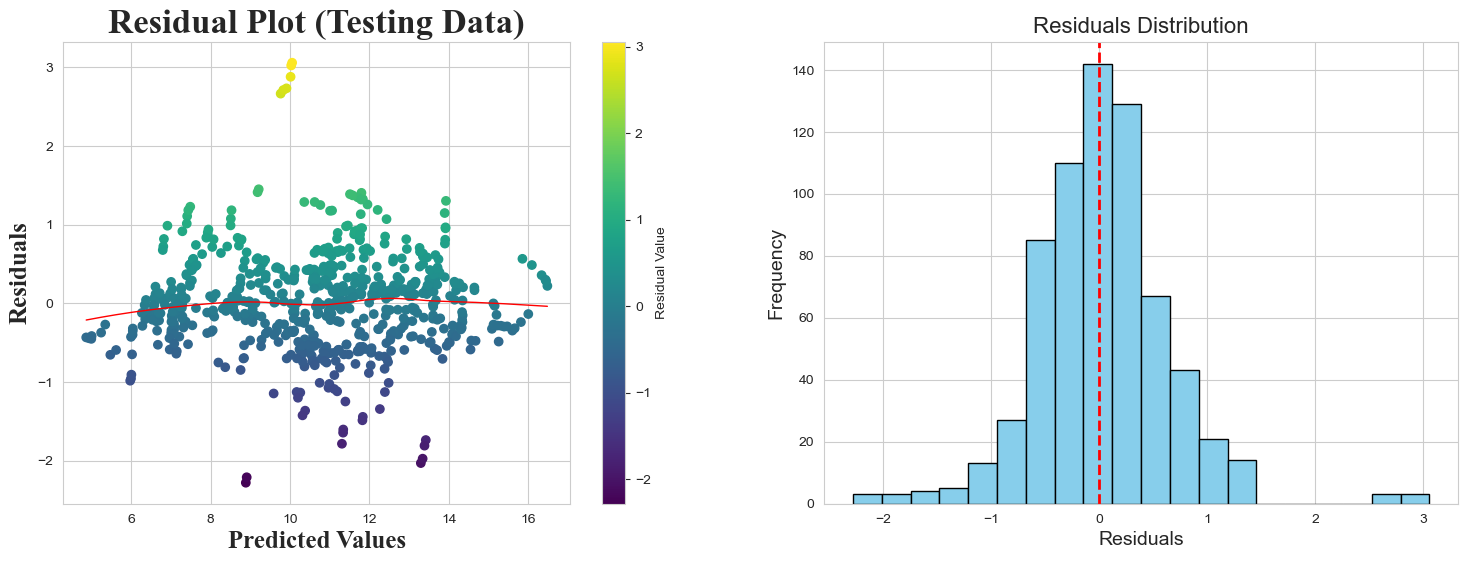

In [98]:
plt.figure(figsize=(18, 6))
# Creating a colored residual plot for testing data
plt.subplot(1, 2, 1)
colored_residual_plot(y_pred_test_poly, residuals, 'Residual Plot (Testing Data)')

plt.subplot(1,2,2)
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")

#### Gradient Boosting regressor

In [99]:
# Initialize the Gradient Boosting regressor
gbr = GradientBoostingRegressor(random_state=42)

# Train the model
gbr.fit(X_train, y_train)

# Get feature importances
feature_importances = gbr.feature_importances_

# Predictions
y_pred_gbr_test = gbr.predict(X_test)

# Evaluation
mae_gbr = mean_absolute_error(y_test, y_pred_gbr_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr_test)
r2_gbr = r2_score(y_test, y_pred_gbr_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr_test))

mae_gbr, mse_gbr, r2_gbr, rmse_gbr

(0.38474429377143776,
 0.28057505592943077,
 0.9550946508596208,
 0.5296933602844487)

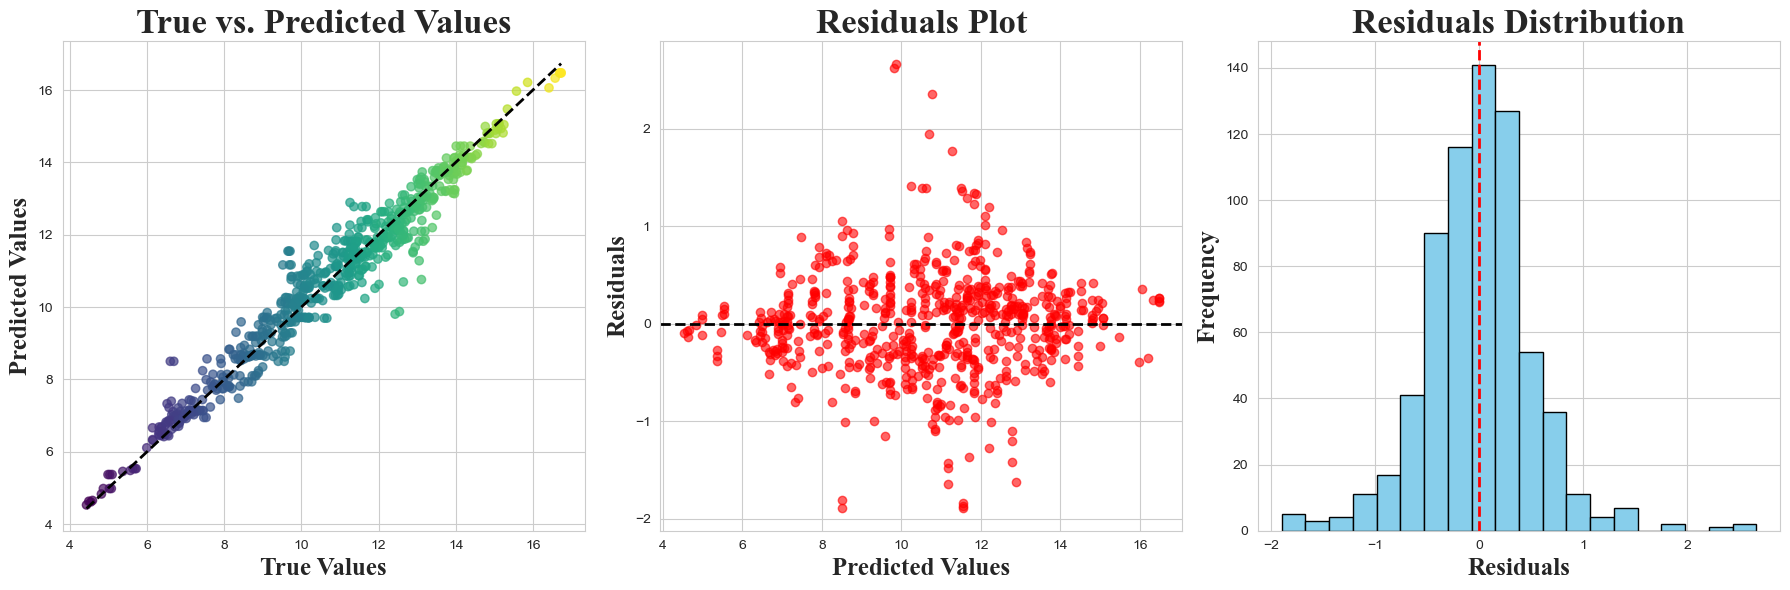

In [100]:
# Visualization of True vs. Predicted Values and Residuals
plt.figure(figsize=(18, 6))

# True vs. Predicted Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_gbr_test, c=y_test, cmap='viridis', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")

# Residuals Plot
plt.subplot(1, 3, 2)
residuals = y_test - y_pred_gbr_test
plt.scatter(y_pred_gbr_test, residuals, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Plot', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.subplot(1,3,3)
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")





plt.tight_layout()
plt.show()


True vs. Predicted Values (Left):

The blue points represent the predicted values against the true values.
The dotted line represents the ideal scenario where every prediction matches the true value.
The closer the blue points are to this line, the better the prediction.


Residuals Plot (Right):

The red points represent the residuals (differences between predicted and true values) for each predicted value.
The horizontal black dashed line represents a residual of zero.
Ideally, we'd like the residuals to be randomly scattered around the horizontal axis, which would indicate that the model's errors are random.

In [101]:


# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42),
                           param_grid, 
                           cv=5, 
                           scoring='r2',
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
 0.9568699918774488)

In [102]:
# Train the Gradient Boosting regressor with best hyperparameters
gbr_best = GradientBoostingRegressor(**best_params, random_state=42)
gbr_best.fit(X_train, y_train)

# Predictions on the test set
y_pred_gbr_best_test = gbr_best.predict(X_test)

# Evaluation
mae_gbr_best = mean_absolute_error(y_test, y_pred_gbr_best_test)
mse_gbr_best = mean_squared_error(y_test, y_pred_gbr_best_test)
r2_gbr_best = r2_score(y_test, y_pred_gbr_best_test)
rmse_gbr_best = np.sqrt(mean_squared_error(y_test, y_pred_gbr_best_test))

mae_gbr_best, mse_gbr_best, r2_gbr_best, rmse_gbr_best

(0.3275770427785561,
 0.22258931028202125,
 0.9643751271472815,
 0.47179371581446616)

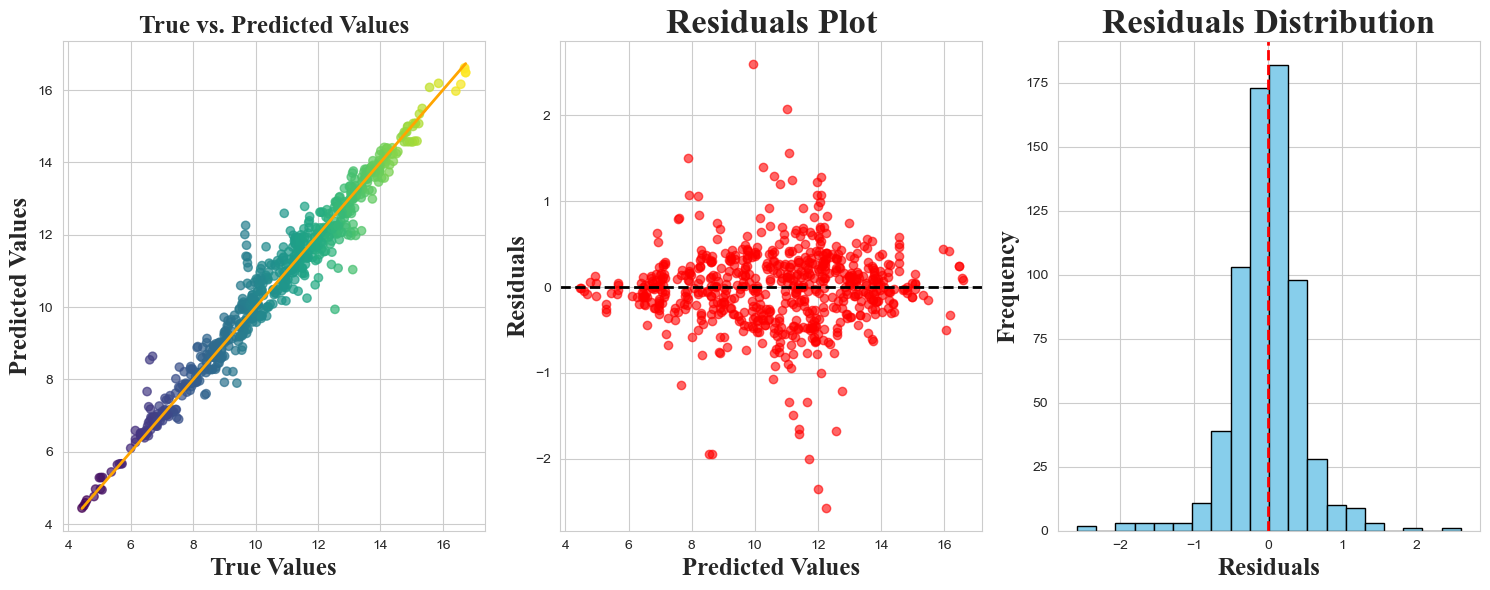

In [103]:
# Visualization of True vs. Predicted Values and Residuals
plt.figure(figsize=(15, 6))

# True vs. Predicted Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_gbr_best_test, c=y_test, cmap='viridis', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2, color= 'orange')
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")

# Residuals Plot
plt.subplot(1, 3, 2)
residuals_best = y_test - y_pred_gbr_best_test
plt.scatter(y_pred_gbr_best_test, residuals_best, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Plot', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.subplot(1,3,3)
plt.hist(residuals_best, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.tight_layout()
plt.show()

True vs. Predicted Values (Left):
The model's predictions are closer to the ideal line, indicating better alignment with the true values.

Residuals Plot (Right):
The residuals are more randomly scattered around the horizontal axis, suggesting the model errors are more random and less biased.

#### SVR 

In [104]:
# Initialize the SVR
svr = SVR()

# Train the model
svr.fit(X_train, y_train)

# Predictions on the test set
y_pred_svr_test = svr.predict(X_test)

# Evaluation
mae_svr = mean_absolute_error(y_test, y_pred_svr_test)
mse_svr = mean_squared_error(y_test, y_pred_svr_test)
r2_svr = r2_score(y_test, y_pred_svr_test)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr_test))

mae_svr, mse_svr, r2_svr, rmse_svr

(0.4391409629668842,
 0.38916648345617266,
 0.9377148593789162,
 0.6238320955643214)

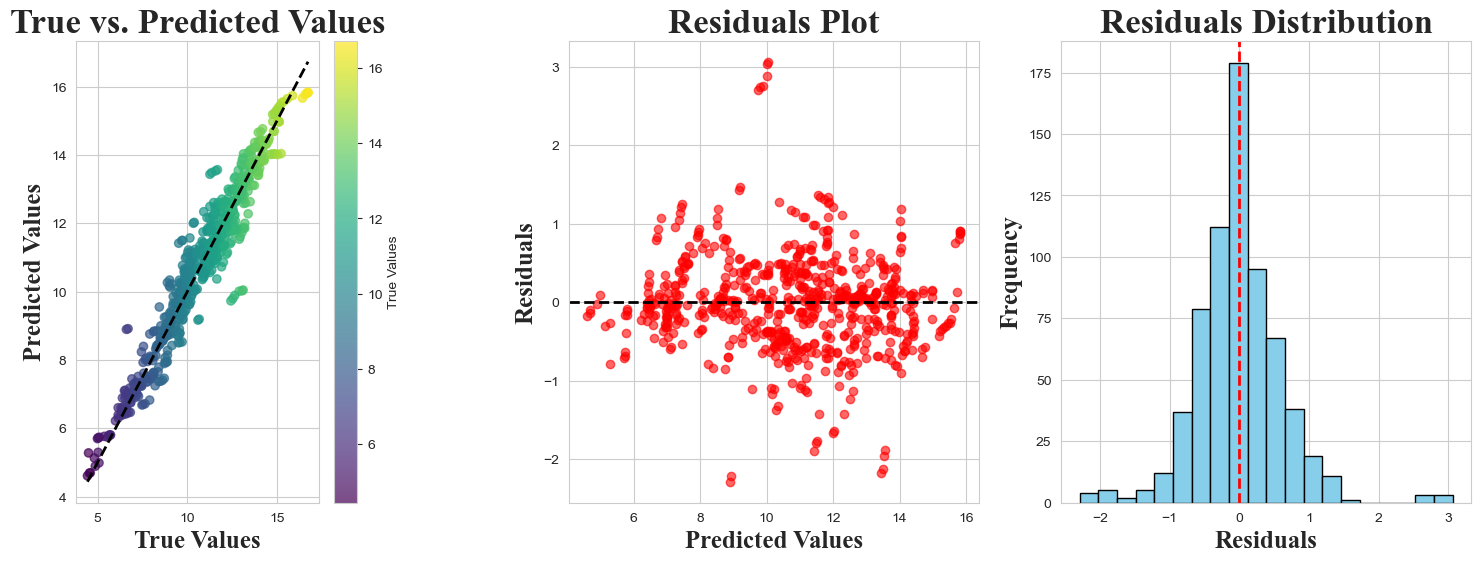

In [105]:
# Visualization
plt.figure(figsize=(18, 6))

# True vs. Predicted Values
plt.subplot(1, 4, 1)
plt.scatter(y_test, y_pred_svr_test, c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar().set_label('True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")

# Residuals Distribution
plt.subplot(1, 3, 2)
residuals_svr = y_test - y_pred_svr_test
plt.scatter(y_pred_svr_test, residuals_svr, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Plot', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.subplot(1, 3, 3)
plt.hist(residuals_svr, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.tight_layout()
plt.show()


### Feature engineering

In [106]:
# Creating polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize the SVR
svr = SVR()

# Train the model
svr.fit(X_train_poly, y_train)

# Predictions on the test set
y_pred_svr_test = svr.predict(X_test_poly)

# Evaluation
mae_svr = mean_absolute_error(y_test, y_pred_svr_test)
mse_svr = mean_squared_error(y_test, y_pred_svr_test)
r2_svr = r2_score(y_test, y_pred_svr_test)
rmse_svr = np.sqrt(mse_svr)

mae_svr, mse_svr, r2_svr, rmse_svr

(0.4611530557097917,
 0.4217724143951001,
 0.9324963601505746,
 0.6494400776015444)

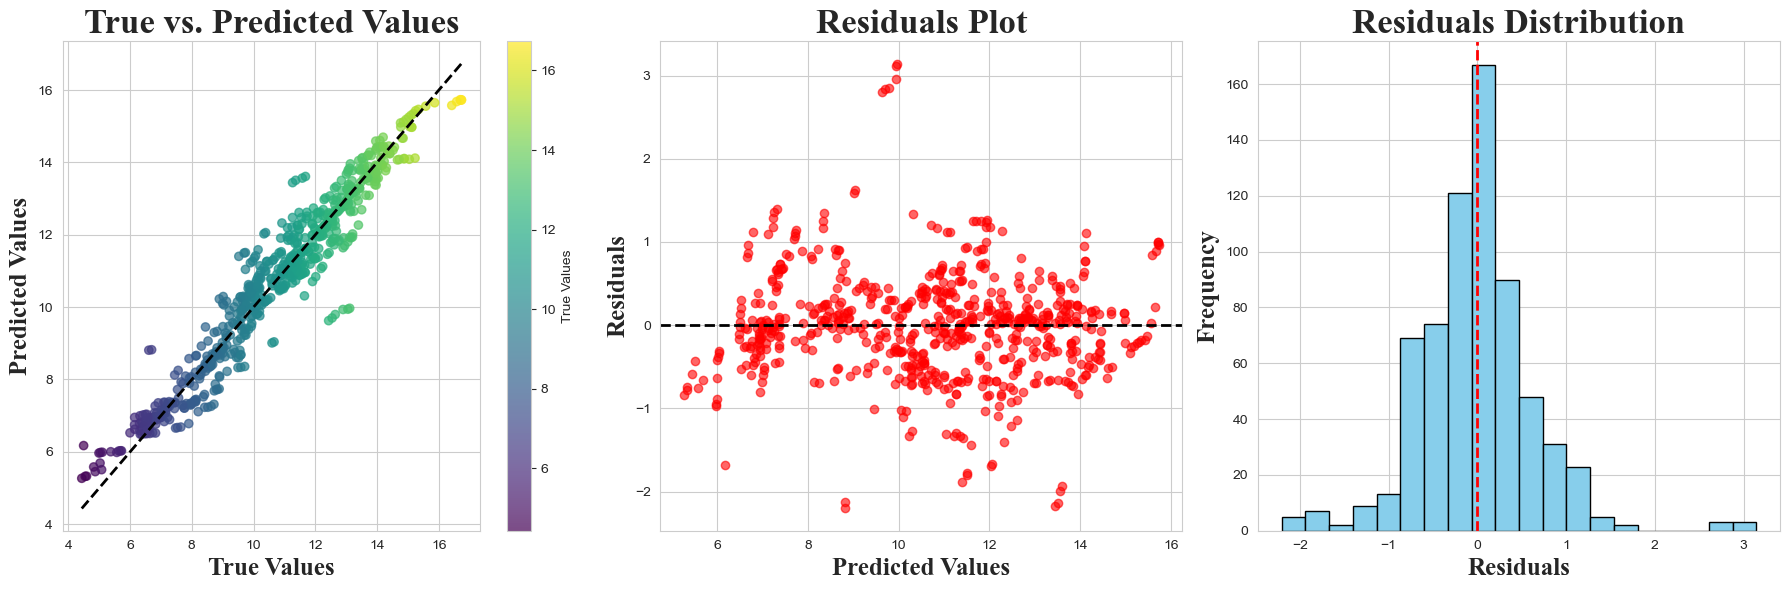

In [107]:
# Visualization
plt.figure(figsize=(18, 6))

# True vs. Predicted Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_svr_test, c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar().set_label('True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")

# Residuals Distribution
plt.subplot(1, 3, 2)
residuals_svr = y_test - y_pred_svr_test
plt.scatter(y_pred_svr_test, residuals_svr, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Plot', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.subplot(1, 3, 3)
plt.hist(residuals_svr, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.tight_layout()
plt.show()


#### Neural Net

In [108]:
# Extracting GDP per capita and per capita plastic waste values
#X = df_per_capita_vs_gdp[['GDP']]
#y = df_per_capita_vs_gdp['Mismanaged Plastics']

X = filtered_data[['Log_GDP', 'Log_Population']]
y = filtered_data['Log_Per Mismanaged Plastics']

In [109]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [110]:
# Creating a neural network model with scaled input
model = Pipeline(steps=[('scaler', StandardScaler()),
                        ('classifier', MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))])

# Training the model
model.fit(X_train, y_train)
# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluating the model R^2
test_score = model.score(X_test, y_test)

# Calculate the Mean Squared Error (test loss)
test_loss = mean_squared_error(y_test, y_pred)

# Calculate the Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

test_score, test_loss, test_mae, rmse

(0.9396833436459346,
 0.37686711169116655,
 0.4516093907299382,
 0.613895033121434)

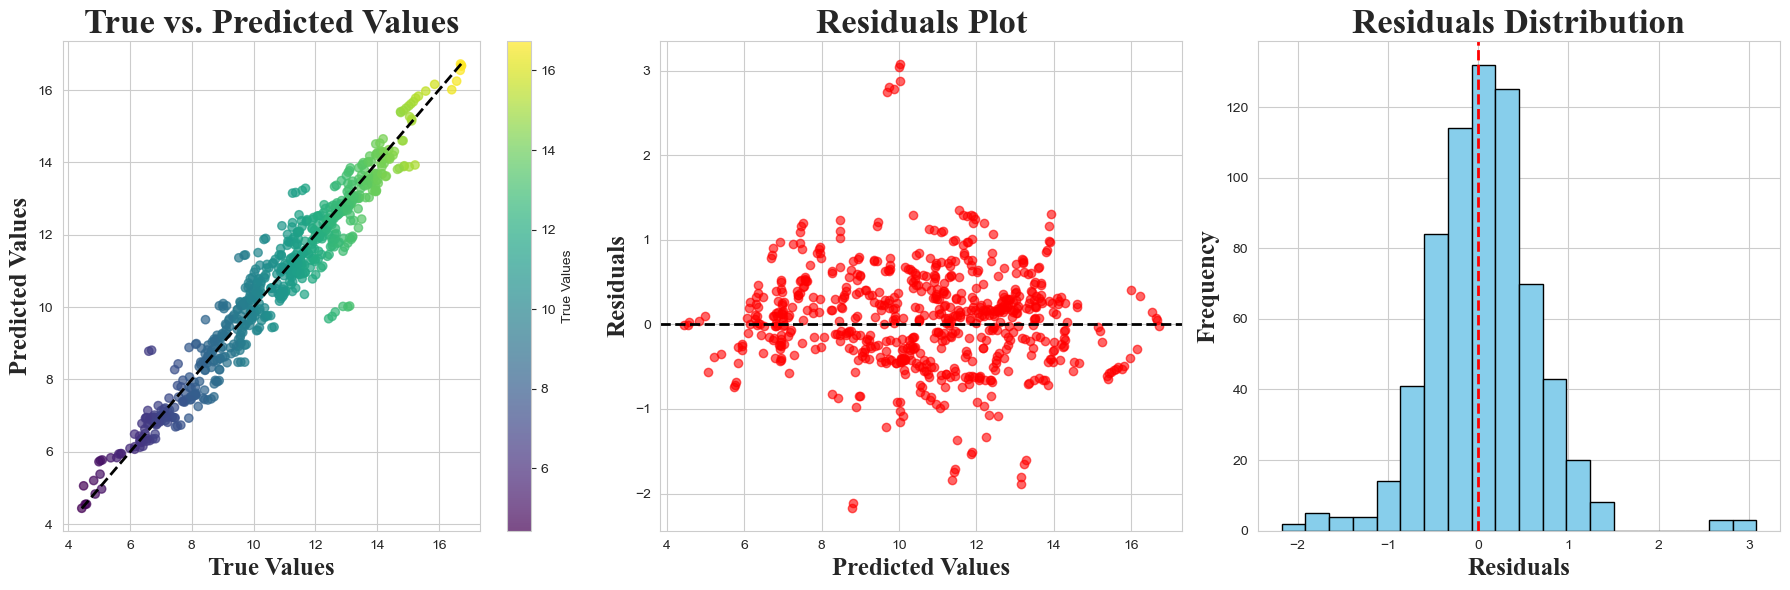

In [111]:
# Visualization
plt.figure(figsize=(18, 6))

# True vs. Predicted Values
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar().set_label('True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")

# Residuals Distribution
plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, color='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Plot', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")

plt.tight_layout()
plt.show()

In [112]:
# Normalizing the features and target variable
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))

X_train_normalized = scaler_X.transform(X_train)
y_train_normalized = scaler_y.transform(y_train.values.reshape(-1, 1))

X_test_normalized = scaler_X.transform(X_test)
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))


In [113]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train_normalized, y_train_normalized, epochs=50, validation_split=0.2, verbose=0)

# Evaluate the model on the test set

test_loss, test_mae = model.evaluate(X_test_normalized, y_test_normalized)
test_loss, test_mae

21/21 [==============================] - 0s 4ms/step - loss: 0.0613 - mae: 0.1812


(0.061322230845689774, 0.18119466304779053)

In [114]:
# Predictions using the neural network on the test set
y_pred_nn = model.predict(X_test_normalized)
y_pred_nn_denormalized = scaler_y.inverse_transform(y_pred_nn)

# Ensuring y_test is a numpy array for consistent arithmetic operations
y_test_array = y_test.to_numpy().reshape(-1, 1)

r2 = r2_score(y_test_array, y_pred_nn_denormalized)
mse = mean_squared_error(y_test_array, y_pred_nn_denormalized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_array, y_pred_nn_denormalized)

# Now you can print or return all the evaluation metrics
r2, mse, rmse, mae

21/21 [==============================] - 1s 3ms/step


(0.9457919566300472,
 0.3386996224615269,
 0.5819790567207096,
 0.4258374317213856)

In [115]:

residuals_nn = y_test_array  - y_pred_nn_denormalized


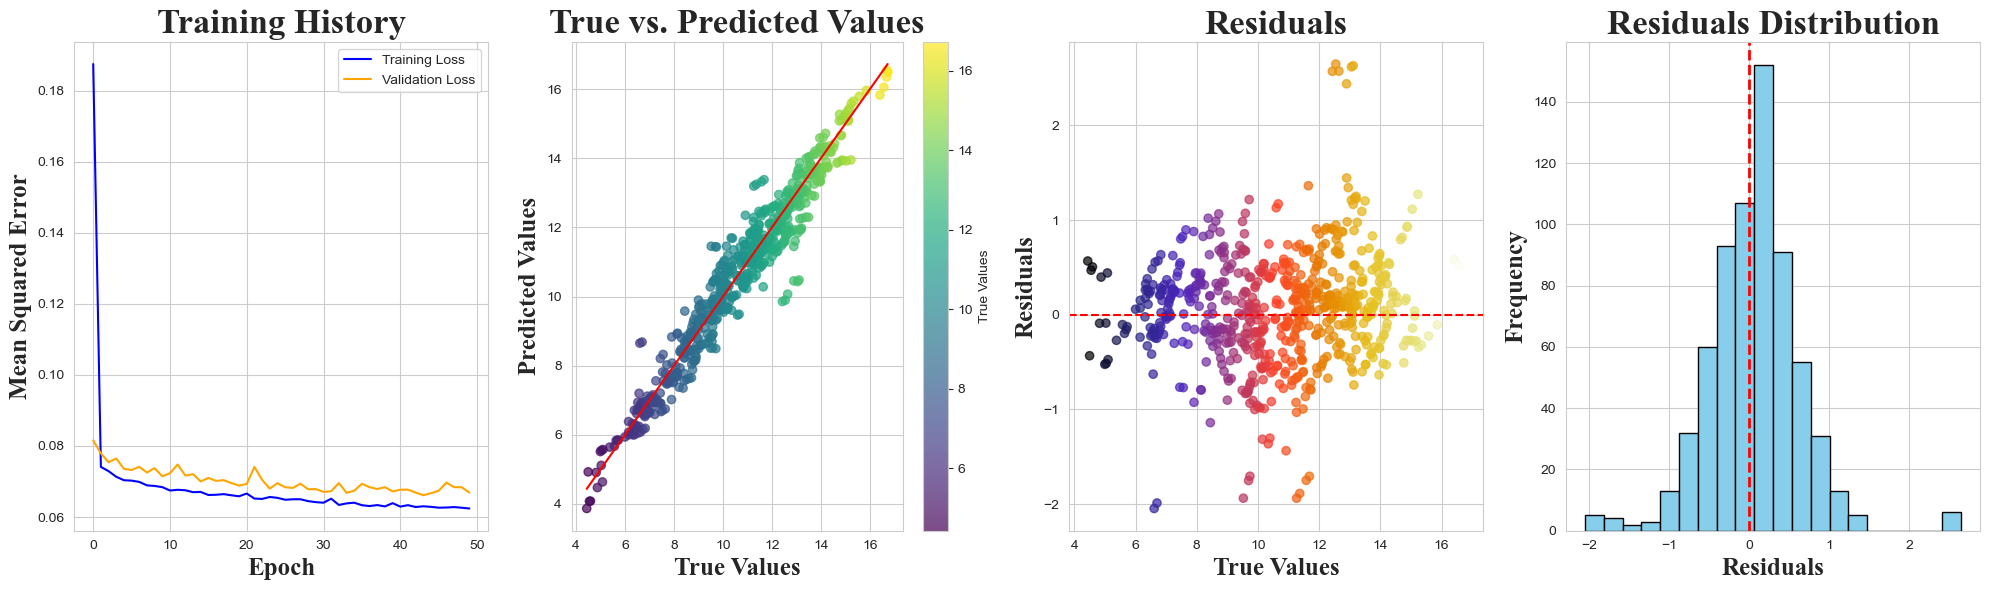

In [116]:

# Visualization
plt.figure(figsize=(20, 6))

# Training History
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Mean Squared Error', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Training History', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.legend()

# True vs. Predicted Values
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_nn_denormalized, c=y_test, cmap='viridis', alpha=0.7)
plt.plot([min(y_test), max(y_test)], 
         [min(y_test), max(y_test)], color='red') 
plt.colorbar().set_label('True Values')
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Subplot for Residuals
plt.subplot(1, 4, 3)
plt.scatter(y_test, residuals_nn, c=y_test, cmap='CMRmap', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at 0
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Residuals Distribution
plt.subplot(1, 4, 4)
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.hist(residuals_nn, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.tight_layout()
plt.show()


#### Fine tuning

Learning rate

In [117]:
# Given our constraints, we'll manually adjust hyperparameters and evaluate the model's performance

# First, we'll adjust the learning rate
learning_rates = [0.01, 0.001, 0.0001, 0.00001]

results = {}

for lr in learning_rates:
    # Define the model with modified learning rate
    model_tuned = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    # Compile the model with adjusted learning rate
    model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=['mae'])

    # Train the model (using a reduced number of epochs for quick iterations)
    model_tuned.fit(X_train_normalized, y_train_normalized, epochs=50, validation_split=0.2, verbose=0)

    # Evaluate the model on the test set
    test_loss_tuned, test_mae_tuned = model_tuned.evaluate(X_test_normalized, scaler_y.transform(y_test.values.reshape(-1, 1)), verbose=0)
    
    results[lr] = (test_loss_tuned, test_mae_tuned)

results


{0.01: (0.05935836583375931, 0.17354734241962433),
 0.001: (0.06343015283346176, 0.18324753642082214),
 0.0001: (0.0676892101764679, 0.19000647962093353),
 1e-05: (0.2109546661376953, 0.34586605429649353)}

Epochs

In [118]:
epochs = [50, 100, 250, 500]

results = {}

for epoch in epochs:

  model_tuned1 = Sequential([
      Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
      Dense(32, activation='relu'),
      Dense(1)
  ])

  model_tuned1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mean_squared_error', metrics=['mae'])

  # Train with different epochs
  model_tuned1.fit(X_train_normalized, y_train_normalized, 
                  epochs=epoch, validation_split=0.2, verbose=0)

  # Evaluate
  test_loss_tuned, test_mae_tuned = model_tuned1.evaluate(
      X_test_normalized, 
      scaler_y.transform(y_test.values.reshape(-1, 1)), verbose=0)

  # Record results
  results[epoch] = (test_loss_tuned, test_mae_tuned)

results

{50: (0.06225358694791794, 0.18030914664268494),
 100: (0.05938078835606575, 0.17673905193805695),
 250: (0.05630574747920036, 0.17172347009181976),
 500: (0.05083928257226944, 0.16480590403079987)}

#### Activations

ReLU is a popular choice due to its simplicity and effectiveness. However, in some cases, other functions like Tanh or Sigmoid might work better.

In [119]:
activations = ['relu', 'tanh', 'sigmoid']

results = {}

for activation in activations:

  model2 = Sequential([
    Dense(64, activation=activation, input_shape=(X_train.shape[1],)), 
    Dense(32, activation=activation),
    Dense(1)
  ])

  model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mean_squared_error', metrics=['mae'])

  # Train with different epochs
  model2.fit(X_train_normalized, y_train_normalized, 
                  epochs=500, validation_split=0.2, verbose=0)

  # Evaluate
  test_loss_tuned, test_mae_tuned = model2.evaluate(
      X_test_normalized, 
      scaler_y.transform(y_test.values.reshape(-1, 1)), verbose=0)

  # Record results
  results[activation] = (test_loss_tuned, test_mae_tuned)

results

{'relu': (0.05400344729423523, 0.1681995391845703),
 'tanh': (0.06176077201962471, 0.18090689182281494),
 'sigmoid': (0.06694428622722626, 0.18778882920742035)}

In [120]:
# Define the neural network model
best_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = best_model.fit(X_train_normalized, y_train_normalized, epochs=500, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(X_test_normalized, scaler_y.transform(y_test.values.reshape(-1, 1)))

test_loss, test_mae

21/21 [==============================] - 0s 6ms/step - loss: 0.0518 - mae: 0.1621


(0.05180765315890312, 0.1620873659849167)

In [121]:
# Predictions using the neural network on the test set
y_pred_nn = best_model.predict(X_test_normalized)

# Predictions using the neural network on the test set
y_pred_nn_denormalized = scaler_y.inverse_transform(y_pred_nn)

# Ensuring y_test is a numpy array for consistent arithmetic operations
y_test_array = y_test.to_numpy().reshape(-1, 1)

r2 = r2_score(y_test_array, y_pred_nn_denormalized)
mse = mean_squared_error(y_test_array, y_pred_nn_denormalized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_array, y_pred_nn_denormalized)

# Now you can print or return all the evaluation metrics
r2, mse, rmse, mae

21/21 [==============================] - 4s 27ms/step


(0.9542027089699279,
 0.2861480366628405,
 0.534928066811642,
 0.38093207139847457)

In [122]:

residuals_nn = y_test_array  - y_pred_nn_denormalized


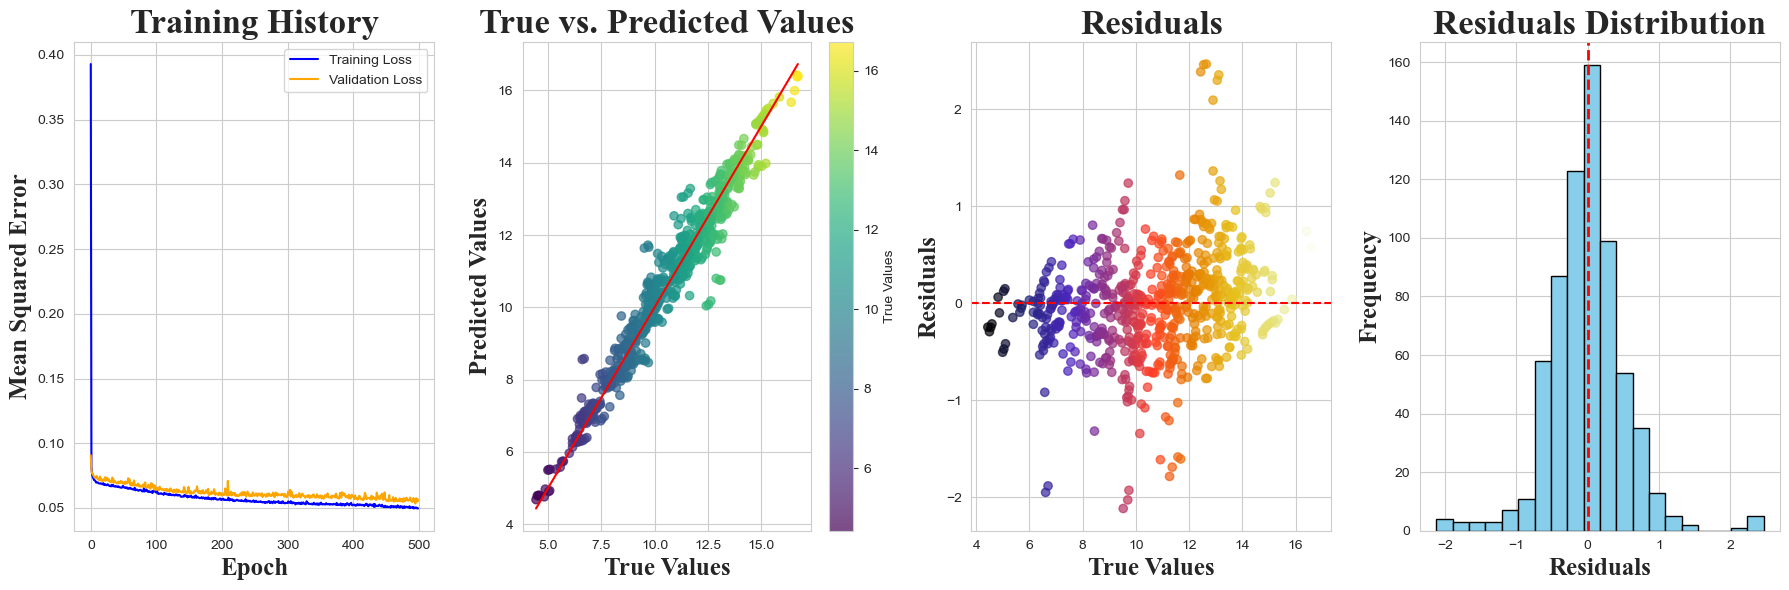

In [123]:

# Visualization
plt.figure(figsize=(18, 6))

# Training History
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Mean Squared Error', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Training History', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.legend()

# True vs. Predicted Values
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_nn_denormalized, c=y_test, cmap='viridis', alpha=0.7)
plt.plot([min(y_test), max(y_test)], 
         [min(y_test), max(y_test)], color='red') 
plt.colorbar().set_label('True Values')
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Subplot for Residuals
plt.subplot(1, 4, 3)
plt.scatter(y_test, residuals_nn, c=y_test, cmap='CMRmap', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at 0
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Residuals Distribution
plt.subplot(1, 4, 4)
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.hist(residuals_nn, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.tight_layout()
plt.show()


#### Trying Regulaization

In [124]:
model_regularized = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(X_train_normalized.shape[1],)),
    Dropout(0.3),  # Dropout layer with 30% dropout rate
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.3),  # Another dropout layer
    Dense(1)
])
# Compile the model
model_regularized.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model_regularized.fit(X_train_normalized, y_train_normalized, epochs=500, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
test_loss, test_mae = model_regularized.evaluate(X_test_normalized, scaler_y.transform(y_test.values.reshape(-1, 1)))

test_loss, test_mae

21/21 [==============================] - 0s 3ms/step - loss: 0.1528 - mae: 0.2108


(0.152756005525589, 0.21084216237068176)

In [125]:
# Predictions using the neural network on the test set
y_pred_nn = model_regularized.predict(X_test_normalized)


# Predictions using the neural network on the test set
y_pred_nn_denormalized = scaler_y.inverse_transform(y_pred_nn)

# Ensuring y_test is a numpy array for consistent arithmetic operations
y_test_array = y_test.to_numpy().reshape(-1, 1)

r2 = r2_score(y_test_array, y_pred_nn_denormalized)
mse = mean_squared_error(y_test_array, y_pred_nn_denormalized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_array, y_pred_nn_denormalized)

# Now you can print or return all the evaluation metrics
r2, mse, rmse, mae

21/21 [==============================] - 0s 4ms/step


(0.9278399956703519,
 0.4508660468793315,
 0.6714655961993373,
 0.4955139221255901)

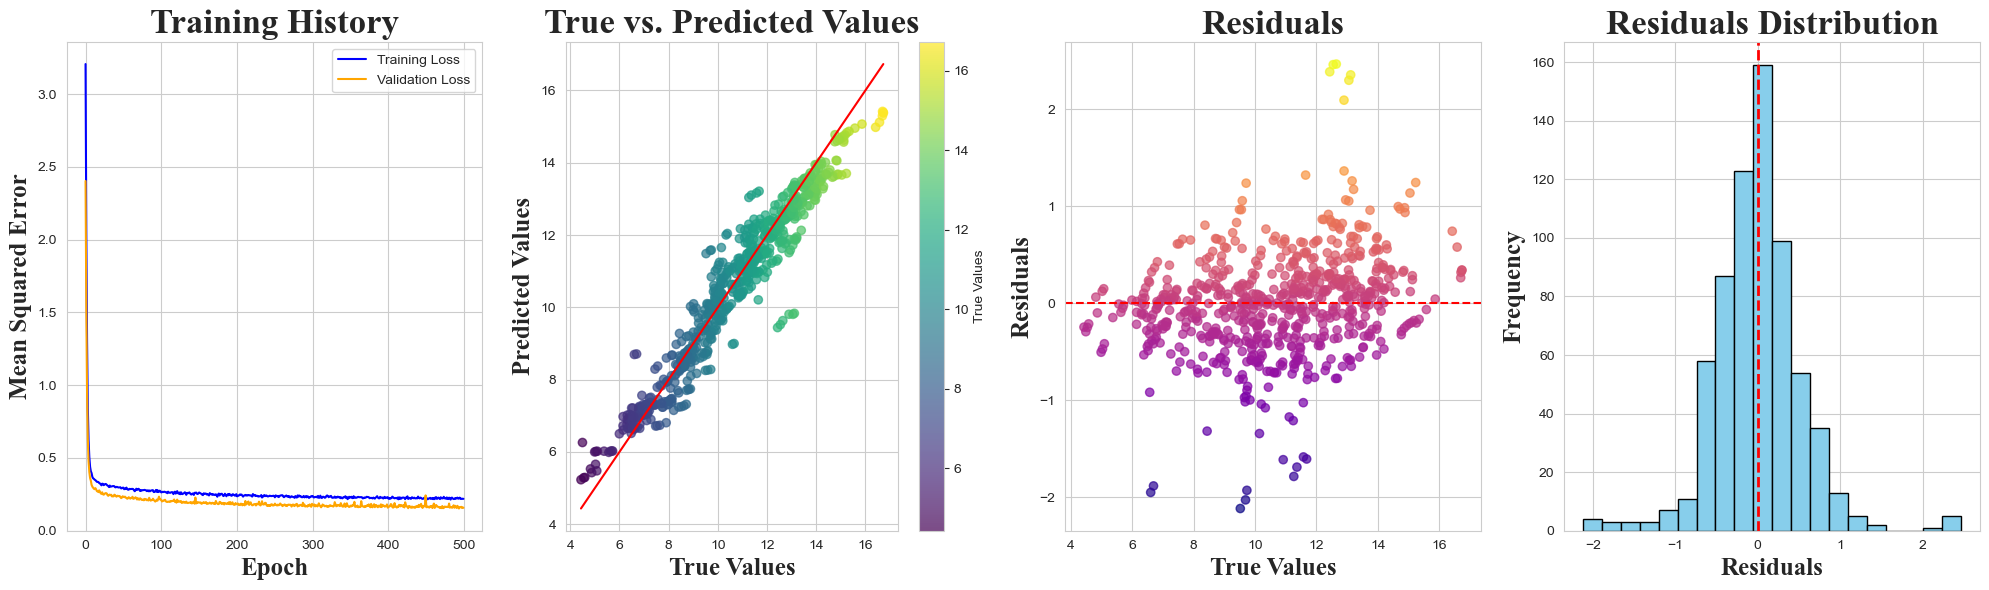

In [126]:

# Visualization
plt.figure(figsize=(20, 6))

# Training History
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Mean Squared Error', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Training History', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.legend()

# True vs. Predicted Values
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_nn_denormalized, c=y_test, cmap='viridis', alpha=0.7)
plt.plot([min(y_test), max(y_test)], 
         [min(y_test), max(y_test)], color='red') 
plt.colorbar().set_label('True Values')
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Predicted Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('True vs. Predicted Values', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Subplot for Residuals
plt.subplot(1, 4, 3)
plt.scatter(y_test, residuals_nn, c=residuals_nn, cmap='plasma', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at 0
plt.xlabel('True Values', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.grid(True)

# Residuals Distribution
plt.subplot(1, 4, 4)
plt.hist(residuals_nn, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Residuals', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.ylabel('Frequency', fontsize=18, fontname="Times New Roman", fontweight="bold")
plt.title('Residuals Distribution', fontsize=25, fontname="Times New Roman", fontweight="bold")


plt.tight_layout()
plt.show()


In [127]:
# Extracting clean GDP per capita and per capita plastic waste values
data_cleaned = filtered_data.dropna(subset=['Log_GDP', 'Log_Population', 
                                  'Log_Per Mismanaged Plastics'])

X_cleaned = filtered_data[['Log_GDP', 'Log_Population']].values
y_cleaned = filtered_data['Log_Per Mismanaged Plastics'].values
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [128]:
# Print first 5 rows
print(X_cleaned[:5]) 


[[21.97040021 14.94336671]
 [22.08989326 14.93398201]
 [22.1929975  14.93098324]
 [22.44808323 14.92724175]
 [22.69521762 14.92306244]]


 23/105 [=====>........................] - ETA: 0s

105/105 [==============================] - 2s 10ms/step


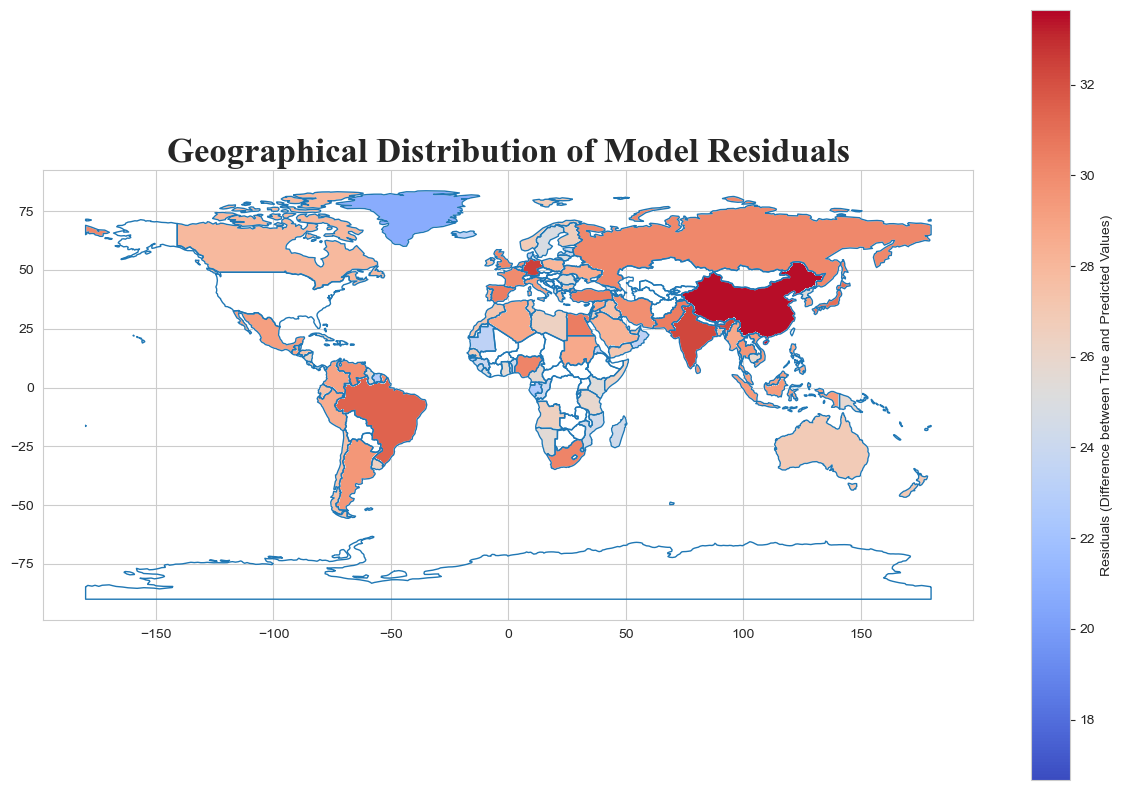

In [129]:
# Predictions using the neural network on the entire dataset
scaler_X = StandardScaler().fit(X_cleaned)
y_pred_all = best_model.predict(scaler_X.transform(X_cleaned))

# Compute residuals for each country
data_cleaned['residuals'] = scaler_y.inverse_transform(y_cleaned.reshape(-1, 1)) - scaler_y.inverse_transform(y_pred_all)

# Merge the world map with the residuals
merged = world.set_index('name').join(data_cleaned.set_index('Country'))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='residuals', ax=ax, legend=True, cmap='coolwarm',
            legend_kwds={'label': 'Residuals (Difference between True and Predicted Values)'})
plt.title('Geographical Distribution of Model Residuals', fontsize=25, fontname="Times New Roman", fontweight="bold")
plt.show()
